In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from scipy import stats

%matplotlib inline
# plt.style.use('ggplot')

# HELPER FUNCTIONS

In [2]:
def read_data(file_path, column_names):
    """Reads the data from the specified file and retrieves the column names
    
    Args:
        file_path: The path of the file as a String
        column_names: Array of Strings representing the names of the colunms
        
    Returns:
        A DataFrame of the read in data
    """
    data = pd.read_csv(file_path, header = 0, names = column_names)
    return data

def feature_normalize(dataset):
    """Normalizes the data in the DataFrame using the mean and sigma values
    
    Args:
        dataset: The DataFrame to normalize
        
    Returns:
        The normalized data
    """
    mu = np.mean(dataset, axis = 0)
    sigma = np.std(dataset, axis = 0)
    return (dataset - mu) / sigma

def basic_feature_normalize(dataset, cols_to_norm):
    """A Basic Normalization of the dataset
    
    Takes the dataset and normalizes it from 0 (min value) to 1 (max value)
    
    Args:
        dataset: The DataFrame to normalize
        cols_to_norm: An Array of strings of the columns that need normalization
        
    Returns:
        The normalized dataset with the specified columns normalized between 0 and 1
    """
    dataset[cols_to_norm] = dataset[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return dataset

def make_rgbs(dataset, cols_to_rgb):
    """Takes a dataset and converts specific columns into rgb values
    
    Args:
        dataset: The DataFrame to convert to rgb values
        cols_to_rgb: An Arrya of strings of the columns that need to be converted
        
    Returns:
        The dataset with the specified columns converted to rgb values
    """
    dataset[cols_to_rgb] = dataset[cols_to_rgb].apply(lambda x: int(x * 255))
    return dataset

def convert_timestamp(dataset):
    """Converts the timestamp to a unix timestamp
    
    Args:
        dataset: The DataFrame with the timestamp column to convert to unix
        
    Returns:
        The dataset with the converted timestamp
    """
    dataset['Timestamp'] = dataset['Timestamp'].apply(lambda x:
                                                     datetime.strptime(x, '%m/%d/%Y %H:%M').timestamp())
    return dataset

def convert_BGA_RFU(dataset, threshold):
    """Converts the BGA_Phycocyanin_RFU column to a true or false value (represented by 1 or 0)
       based on the threshold value
       
    Args:
        dataset: The DataFrame with the BGA_Phycocyanin_RFU value to be adjusted
        threshold: The minimum value for an algae bloom to be true
        
    Returns:
        The dataset with the converted BGA_RFU value"""
    dataset['BGA_Phycocyanin_RFU'] = dataset['BGA_Phycocyanin_RFU'].apply(lambda x: 1 if x >= threshold else 0)
    return dataset

# Batch Creation

In [3]:
# We step 50% down based on window size
def windows(data, size):
    counter_output = 0
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 8)
        counter_output += 1
        if counter_output % 10 == 0:
            print('Window Segmentation {0:.2f}% done'.format((start / data.count()) * 100))
    
# 32 chosen for 8 hours of 15 minute intervals
# TODO: NEED TO PASS IN COLUMNS AND DETERMINE FROM THAT
def segment_signal(dataset, window_size = 90, columns = 5):
    segments = np.empty((0, window_size, columns))
    labels = np.empty((0))
    count = 0;
    for (start, end) in windows(dataset["Timestamp"], window_size):
        temperature = dataset['Temperature'][start:end]
        temp_2_hour = dataset['Temp_2_Hour'][start:end]
        temp_4_hour = dataset['Temp_4_Hour'][start:end]
        temp_8_hour = dataset['Temp_8_Hour'][start:end]
        conductivity = dataset['Sp_Cond'][start:end]
        cond_2_hour = dataset['Sp_Cond_2_Hour'][start:end]
        cond_4_hour = dataset['Sp_Cond_4_Hour'][start:end]
        cond_8_hour = dataset['Sp_Cond_8_Hour'][start:end]
        turbidity = dataset['Turbidity'][start:end]
        turb_2_hour = dataset['Turbidity_2_Hour'][start:end]
        turb_4_hour = dataset['Turbidity_4_Hour'][start:end]
        turb_8_hour = dataset['Turbidity_8_Hour'][start:end]
        odo = dataset['ODO'][start:end]
        odo_2_hour = dataset['ODO_2_Hour'][start:end]
        odo_4_hour = dataset['ODO_4_Hour'][start:end]
        odo_8_hour = dataset['ODO_8_Hour'][start:end]
        
        if(len(dataset['Timestamp'][start:end]) == window_size):
            segments = np.vstack([segments, np.dstack([temperature, temp_2_hour, temp_4_hour, temp_8_hour,
                                                       conductivity, cond_2_hour, cond_4_hour, cond_8_hour,
                                                       turbidity, turb_2_hour, turb_4_hour, turb_8_hour,
                                                       odo, odo_2_hour, odo_4_hour, odo_8_hour])])
            labels = np.append(labels, stats.mode(dataset['BGA_Phycocyanin_RFU'][start:end])[0][0])
    return segments, labels

# Setup the Lake_Dataset

In [4]:
cols = ['Timestamp',
        'Temperature', 'Temp_2_Hour', 'Temp_4_Hour', 'Temp_8_Hour',
        'Sp_Cond', 'Sp_Cond_2_Hour', 'Sp_Cond_4_Hour', 'Sp_Cond_8_Hour',
        'Turbidity', 'Turbidity_2_Hour', 'Turbidity_4_Hour', 'Turbidity_8_Hour',
        'ODO', 'ODO_2_Hour', 'ODO_4_Hour', 'ODO_8_Hour',
        'BGA_Phycocyanin_RFU']

# cols_to_keep = []
# cols_to_keep.append('Timestamp')
# cols_to_keep.append('Temperature')
# cols_to_keep.append('Sp_Cond')
# # cols_to_keep.append('pH_mV')
# # cols_to_keep.append('pH')
# cols_to_keep.append('Turbidity')
# # cols_to_keep.append('Chlorophyll')
# # cols_to_keep.append('Chlorophyll_RFU')
# # cols_to_keep.append('ODOSat')
# cols_to_keep.append('ODO')
# cols_to_keep.append('BGA_Phycocyanin_RFU')

lake_dataset = read_data('./data/cleaned/utah_lake_vineyard - averages.csv', cols) 

# for col in cols:
#     if col not in cols_to_keep:
#         lake_dataset = lake_dataset.drop(col, axis=1)
#         
lake_dataset.head()

,Timestamp,Temperature,Temp_2_Hour,Temp_4_Hour,Temp_8_Hour,Sp_Cond,Sp_Cond_2_Hour,Sp_Cond_4_Hour,Sp_Cond_8_Hour,Turbidity,Turbidity_2_Hour,Turbidity_4_Hour,Turbidity_8_Hour,ODO,ODO_2_Hour,ODO_4_Hour,ODO_8_Hour,BGA_Phycocyanin_RFU
0,5/5/2017 8:00,14.35,14.40375,14.504706,14.675152,1863,1862.250,1859.411765,1855.121212,15.46,15.70750,15.880000,16.204062,8.92,8.89375,8.910000,8.954848,0.4
1,5/5/2017 8:15,14.37,14.39250,14.485882,14.655455,1863,1862.750,1859.882353,1855.575758,15.57,15.66625,15.838125,16.163438,8.93,8.89875,8.908235,8.951515,0.4
2,5/5/2017 8:30,14.38,14.38375,14.469412,14.636970,1863,1862.750,1860.294118,1856.060606,15.38,15.66875,15.795000,16.124375,8.94,8.90625,8.907647,8.948485,0.4
3,5/5/2017 8:45,14.42,14.38125,14.457059,14.620606,1863,1862.625,1860.647059,1856.545455,15.43,15.62000,15.746875,16.067812,8.95,8.91500,8.908235,8.945758,0.4
4,5/5/2017 9:00,14.43,14.38250,14.445882,14.604848,1864,1862.875,1861.058824,1857.030303,15.50,15.56125,15.720625,16.023438,8.95,8.92375,8.909412,8.943333,0.4


In [5]:
type(lake_dataset)

pandas.core.frame.DataFrame

In [6]:
lake_dataset.head()

,Timestamp,Temperature,Temp_2_Hour,Temp_4_Hour,Temp_8_Hour,Sp_Cond,Sp_Cond_2_Hour,Sp_Cond_4_Hour,Sp_Cond_8_Hour,Turbidity,Turbidity_2_Hour,Turbidity_4_Hour,Turbidity_8_Hour,ODO,ODO_2_Hour,ODO_4_Hour,ODO_8_Hour,BGA_Phycocyanin_RFU
0,5/5/2017 8:00,14.35,14.40375,14.504706,14.675152,1863,1862.250,1859.411765,1855.121212,15.46,15.70750,15.880000,16.204062,8.92,8.89375,8.910000,8.954848,0.4
1,5/5/2017 8:15,14.37,14.39250,14.485882,14.655455,1863,1862.750,1859.882353,1855.575758,15.57,15.66625,15.838125,16.163438,8.93,8.89875,8.908235,8.951515,0.4
2,5/5/2017 8:30,14.38,14.38375,14.469412,14.636970,1863,1862.750,1860.294118,1856.060606,15.38,15.66875,15.795000,16.124375,8.94,8.90625,8.907647,8.948485,0.4
3,5/5/2017 8:45,14.42,14.38125,14.457059,14.620606,1863,1862.625,1860.647059,1856.545455,15.43,15.62000,15.746875,16.067812,8.95,8.91500,8.908235,8.945758,0.4
4,5/5/2017 9:00,14.43,14.38250,14.445882,14.604848,1864,1862.875,1861.058824,1857.030303,15.50,15.56125,15.720625,16.023438,8.95,8.92375,8.909412,8.943333,0.4


# Charts

## Temperature

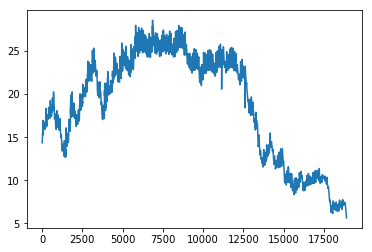

In [7]:
plt.plot(lake_dataset['Temperature'])

## Conductivity

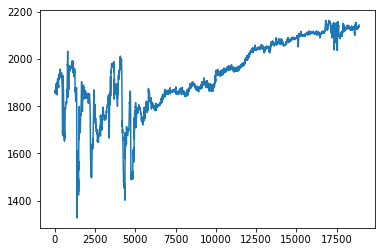

In [8]:
plt.plot(lake_dataset['Sp_Cond'])

## Turbidity

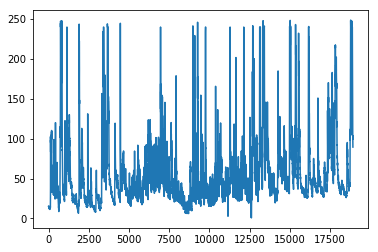

In [9]:
plt.plot(lake_dataset['Turbidity'])

## Turbidity 2/4/8 Hour Averages

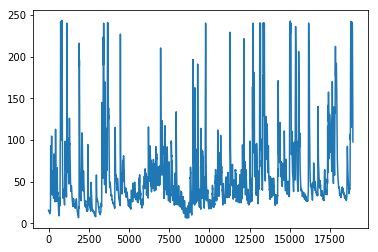

In [10]:
plt.plot(lake_dataset['Turbidity_2_Hour'])

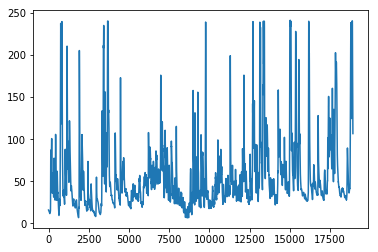

In [11]:
plt.plot(lake_dataset['Turbidity_4_Hour'])

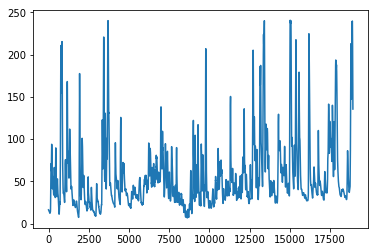

In [12]:
plt.plot(lake_dataset['Turbidity_8_Hour'])

## ODO

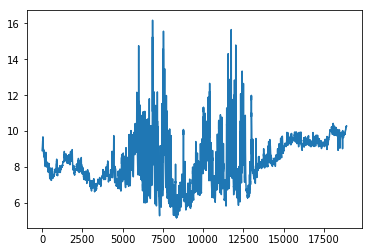

In [13]:
plt.plot(lake_dataset['ODO'])

## Blue Green Algae RFU

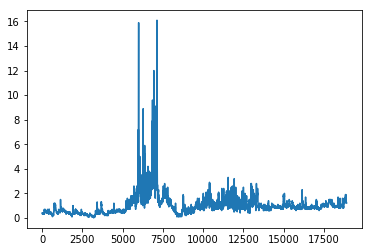

In [14]:
plt.plot(lake_dataset['BGA_Phycocyanin_RFU'])

# NORMALIZE THE DATA

In [15]:
lake_dataset = convert_timestamp(lake_dataset)
lake_dataset = convert_BGA_RFU(lake_dataset, 1.0)
normalized_lake_dataset = basic_feature_normalize(lake_dataset, [
    'Temperature', 'Temp_2_Hour', 'Temp_4_Hour', 'Temp_8_Hour',
    'Sp_Cond', 'Sp_Cond_2_Hour', 'Sp_Cond_4_Hour', 'Sp_Cond_8_Hour',
    'Turbidity', 'Turbidity_2_Hour', 'Turbidity_4_Hour', 'Turbidity_8_Hour',
    'ODO', 'ODO_2_Hour', 'ODO_4_Hour', 'ODO_8_Hour'])
normalized_lake_dataset.head()

,Timestamp,Temperature,Temp_2_Hour,Temp_4_Hour,Temp_8_Hour,Sp_Cond,Sp_Cond_2_Hour,Sp_Cond_4_Hour,Sp_Cond_8_Hour,Turbidity,Turbidity_2_Hour,Turbidity_4_Hour,Turbidity_8_Hour,ODO,ODO_2_Hour,ODO_4_Hour,ODO_8_Hour,BGA_Phycocyanin_RFU
0,1.493989e+09,0.380122,0.391545,0.399115,0.408474,0.640382,0.606627,0.588259,0.573527,0.059706,0.039012,0.039886,0.040814,0.340909,0.372881,0.412914,0.461778,0
1,1.493990e+09,0.380994,0.391037,0.398252,0.407552,0.640382,0.607283,0.588900,0.574162,0.060150,0.038838,0.039707,0.040641,0.341818,0.373387,0.412714,0.461349,0
2,1.493991e+09,0.381430,0.390642,0.397496,0.406686,0.640382,0.607283,0.589462,0.574839,0.059384,0.038848,0.039524,0.040474,0.342727,0.374146,0.412648,0.460959,0
3,1.493992e+09,0.383173,0.390529,0.396930,0.405920,0.640382,0.607119,0.589943,0.575516,0.059585,0.038643,0.039318,0.040232,0.343636,0.375032,0.412714,0.460608,0
4,1.493993e+09,0.383609,0.390585,0.396417,0.405182,0.641577,0.607448,0.590504,0.576194,0.059868,0.038395,0.039207,0.040042,0.343636,0.375917,0.412847,0.460296,0


In [16]:
normalized_lake_dataset['Temperature'].max()

1.0

In [17]:
normalized_lake_dataset['Temperature'].min()

0.0

In [18]:
normalized_lake_dataset['BGA_Phycocyanin_RFU'].max()

1

In [19]:
normalized_lake_dataset.shape

(18915, 18)

In [20]:
type(normalized_lake_dataset)

pandas.core.frame.DataFrame

# Retrieve the segments and labels - 4 Hour (Four 15 Minute Intervals = 16)

In [21]:
segments, labels = segment_signal(normalized_lake_dataset, 16, 16)

Window Segmentation 0.11% done
Window Segmentation 0.21% done
Window Segmentation 0.32% done
Window Segmentation 0.42% done
Window Segmentation 0.53% done
Window Segmentation 0.63% done
Window Segmentation 0.74% done
Window Segmentation 0.85% done
Window Segmentation 0.95% done
Window Segmentation 1.06% done
Window Segmentation 1.16% done
Window Segmentation 1.27% done
Window Segmentation 1.37% done
Window Segmentation 1.48% done
Window Segmentation 1.59% done
Window Segmentation 1.69% done
Window Segmentation 1.80% done
Window Segmentation 1.90% done
Window Segmentation 2.01% done
Window Segmentation 2.11% done
Window Segmentation 2.22% done
Window Segmentation 2.33% done
Window Segmentation 2.43% done
Window Segmentation 2.54% done
Window Segmentation 2.64% done
Window Segmentation 2.75% done
Window Segmentation 2.85% done
Window Segmentation 2.96% done
Window Segmentation 3.07% done
Window Segmentation 3.17% done
Window Segmentation 3.28% done
Window Segmentation 3.38% done
Window S

Window Segmentation 27.49% done
Window Segmentation 27.60% done
Window Segmentation 27.70% done
Window Segmentation 27.81% done
Window Segmentation 27.91% done
Window Segmentation 28.02% done
Window Segmentation 28.13% done
Window Segmentation 28.23% done
Window Segmentation 28.34% done
Window Segmentation 28.44% done
Window Segmentation 28.55% done
Window Segmentation 28.65% done
Window Segmentation 28.76% done
Window Segmentation 28.87% done
Window Segmentation 28.97% done
Window Segmentation 29.08% done
Window Segmentation 29.18% done
Window Segmentation 29.29% done
Window Segmentation 29.39% done
Window Segmentation 29.50% done
Window Segmentation 29.61% done
Window Segmentation 29.71% done
Window Segmentation 29.82% done
Window Segmentation 29.92% done
Window Segmentation 30.03% done
Window Segmentation 30.13% done
Window Segmentation 30.24% done
Window Segmentation 30.35% done
Window Segmentation 30.45% done
Window Segmentation 30.56% done
Window Segmentation 30.66% done
Window S

Window Segmentation 54.77% done
Window Segmentation 54.88% done
Window Segmentation 54.98% done
Window Segmentation 55.09% done
Window Segmentation 55.19% done
Window Segmentation 55.30% done
Window Segmentation 55.41% done
Window Segmentation 55.51% done
Window Segmentation 55.62% done
Window Segmentation 55.72% done
Window Segmentation 55.83% done
Window Segmentation 55.93% done
Window Segmentation 56.04% done
Window Segmentation 56.15% done
Window Segmentation 56.25% done
Window Segmentation 56.36% done
Window Segmentation 56.46% done
Window Segmentation 56.57% done
Window Segmentation 56.67% done
Window Segmentation 56.78% done
Window Segmentation 56.89% done
Window Segmentation 56.99% done
Window Segmentation 57.10% done
Window Segmentation 57.20% done
Window Segmentation 57.31% done
Window Segmentation 57.41% done
Window Segmentation 57.52% done
Window Segmentation 57.63% done
Window Segmentation 57.73% done
Window Segmentation 57.84% done
Window Segmentation 57.94% done
Window S

Window Segmentation 82.16% done
Window Segmentation 82.26% done
Window Segmentation 82.37% done
Window Segmentation 82.47% done
Window Segmentation 82.58% done
Window Segmentation 82.69% done
Window Segmentation 82.79% done
Window Segmentation 82.90% done
Window Segmentation 83.00% done
Window Segmentation 83.11% done
Window Segmentation 83.21% done
Window Segmentation 83.32% done
Window Segmentation 83.43% done
Window Segmentation 83.53% done
Window Segmentation 83.64% done
Window Segmentation 83.74% done
Window Segmentation 83.85% done
Window Segmentation 83.95% done
Window Segmentation 84.06% done
Window Segmentation 84.17% done
Window Segmentation 84.27% done
Window Segmentation 84.38% done
Window Segmentation 84.48% done
Window Segmentation 84.59% done
Window Segmentation 84.69% done
Window Segmentation 84.80% done
Window Segmentation 84.91% done
Window Segmentation 85.01% done
Window Segmentation 85.12% done
Window Segmentation 85.22% done
Window Segmentation 85.33% done
Window S

In [22]:
segments.shape

(9450, 16, 16)

In [23]:
reshaped_segments = segments.reshape(len(segments), 1, 16, 16)
reshaped_segments.shape

(9450, 1, 16, 16)

## No Algae Bloom. Beginning of Summer (May 5th)

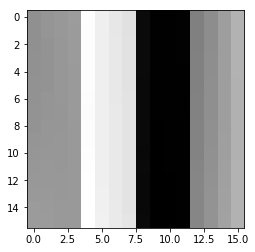

In [24]:
plt.imshow(reshaped_segments[0][0] * 255, cmap='gray')

## Algae Bloom. July 7th

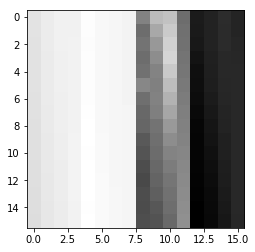

In [25]:
plt.imshow(reshaped_segments[6070][0] * 255, cmap='gray')

## Algae Bloom. July 9th

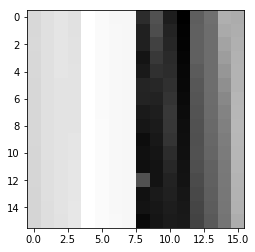

In [26]:
plt.imshow(reshaped_segments[6260][0] * 255, cmap='gray')

In [27]:
reshaped_segments_as_image = segments.reshape(len(segments), 4, 4, 16)

In [28]:
segments.shape

(9450, 16, 16)

In [29]:
reshaped_segments_as_image.shape

(9450, 4, 4, 16)

In [30]:
labels.shape

(9450,)

In [31]:
new_labels = np.zeros((len(labels), 2))
new_labels.shape

(9450, 2)

In [32]:
iter = 0
while(iter < len(labels)):
    if labels[iter] > 0.0:
        print(iter)
    new_labels[iter][int(labels[iter])] = 1
    iter = iter + 1

367
368
369
370
371
372
373
390
391
392
393
394
395
404
405
406
407
408
409
410
411
412
413
565
566
567
568
569
1704
1705
1706
1707
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
2602
2603
2645
2646
2647
2651
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
286

In [33]:
new_labels[1500:2000]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,

# Break apart the training and test data

In [34]:
from sklearn.model_selection import train_test_split

class CNNHelper():
    
    def __init__(self):
        self.iterator = 0
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(reshaped_segments_as_image, new_labels, test_size=0.3, random_state=101)

    def next_batch(self, batch_size):
        x = self.X_train[self.iterator:self.iterator + batch_size]
        y = self.y_train[self.iterator:self.iterator + batch_size]
        self.iterator = (self.iterator + batch_size) % len(self.X_train)
        return x, y

# CREATE THE MODEL

In [35]:
x = tf.placeholder(tf.float32, shape=[None, 4, 4, 16])
y_true = tf.placeholder(tf.float32, shape=[None, 2])

In [36]:
hold_prob = tf.placeholder(tf.float32)

In [37]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [38]:
convo_1 = convolutional_layer(x,shape=[2,2,16,256])
convo_1_pooling = max_pool_2by2(convo_1)

In [39]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[2,2,256,512])
convo_2_pooling = max_pool_2by2(convo_2)
convo_2.shape

TensorShape([Dimension(None), Dimension(2), Dimension(2), Dimension(512)])

In [40]:
convo_2_flat = tf.reshape(convo_2_pooling, [-1,512])

In [41]:
convo_2_flat.shape

TensorShape([Dimension(None), Dimension(512)])

In [42]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,64))

In [43]:
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [44]:
full_one_dropout.shape

TensorShape([Dimension(None), Dimension(64)])

In [45]:
y_pred = normal_full_layer(full_one_dropout,2)
y_pred.shape

TensorShape([Dimension(None), Dimension(2)])

## Loss Function

In [46]:
y_pred.shape

TensorShape([Dimension(None), Dimension(2)])

In [47]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

In [48]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [49]:
init = tf.global_variables_initializer()
cnn_helper = CNNHelper()

In [50]:
cnn_helper.X_test.shape

(2835, 4, 4, 16)

In [51]:
cnn_helper.y_test.shape

(2835, 2)

In [52]:
cnn_helper.y_train.shape

(6615, 2)

In [53]:
# cnn_helper.X_test[0]

In [54]:
# cnn_helper.X_test = np.zeros((1892, 6, 6, 3))
# cnn_helper.X_test[0]

In [55]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost_history = []
    acc_history = []

    for i in range(4000):
        batch = cnn_helper.next_batch(100)
        _, c = sess.run([train, cross_entropy], feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
        cost_history.append(c)
        
        matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
        acc = tf.reduce_mean(tf.cast(matches,tf.float32))
        acc_history.append(sess.run(acc,feed_dict={x:cnn_helper.X_test,y_true:cnn_helper.y_test,hold_prob:1.0}))
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:cnn_helper.X_test,y_true:cnn_helper.y_test,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.397884


Currently on step 100
Accuracy is:
0.81164


Currently on step 200
Accuracy is:
0.853968


Currently on step 300
Accuracy is:
0.858201


Currently on step 400
Accuracy is:
0.868783


Currently on step 500
Accuracy is:
0.873721


Currently on step 600
Accuracy is:
0.885009


Currently on step 700
Accuracy is:
0.879012


Currently on step 800
Accuracy is:
0.87478


Currently on step 900
Accuracy is:
0.888889


Currently on step 1000
Accuracy is:
0.883245


Currently on step 1100
Accuracy is:
0.895238


Currently on step 1200
Accuracy is:
0.893122


Currently on step 1300
Accuracy is:
0.893122


Currently on step 1400
Accuracy is:
0.908289


Currently on step 1500
Accuracy is:
0.897002


Currently on step 1600
Accuracy is:
0.902998


Currently on step 1700
Accuracy is:
0.897707


Currently on step 1800
Accuracy is:
0.898765


Currently on step 1900
Accuracy is:
0.912169


Currently on step 2000
Accuracy is:
0.890653


Currently on step 2100
Accu

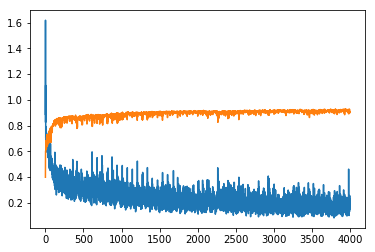

In [56]:
plt.plot(cost_history)
plt.plot(acc_history)
plt.figure(figsize=(40,20))
plt.show()
# acc_history

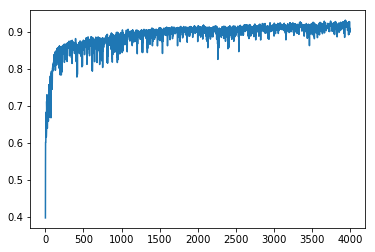

In [57]:
plt.plot(acc_history)

In [58]:
matches

<tf.Tensor 'Equal_4039:0' shape=(?,) dtype=bool>

In [59]:
matches.eval()

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`